### Meandering demo overview

Anchors:
- `analog_image_generator.geologic_generators.generate_meandering`
- `analog_image_generator.stacked_channels.build_stacked_fluvial`
- `analog_image_generator.stats.compute_metrics`
- `analog_image_generator.reporting.build_reports`

Use this notebook to demonstrate the features listed below. Fill in the upcoming sections (presets, generator runs, stacked packages, metrics, reporting, and debugging hooks) before the professor review.


# Fluvial Meandering Anchors
Traceability notebook for the meandering functions implemented in `src/analog_image_generator/geologic_generators.py`.

#### Demo checklist

- [ ] Parameter presets referencing `_MEANDER_DEFAULTS`
- [ ] Single-belt generator run cell (grayscale + masks)
- [ ] Stacked package run cell with relief/metadata display
- [ ] Visualization panel (gray, color, package_id map, legend)
- [ ] Metrics summary using `stats.compute_metrics`
- [ ] Reporting hook (CSV/PDF snippet or smoke link)
- [ ] Debug controls for seed/package toggles + Task Master notes


In [18]:
from analog_image_generator import geologic_generators as gg

MEANDER_BASELINE = {
    "style": "meandering",
    "height": 256,
    "width": 256,
    "seed": 42,
    "n_control_points": gg._MEANDER_DEFAULTS["n_control_points"],
    "amplitude_range": gg._MEANDER_DEFAULTS["amplitude_range"],
    "drift_fraction": gg._MEANDER_DEFAULTS["drift_fraction"],
    "channel_width_min": gg._MEANDER_DEFAULTS["channel_width_min"],
    "channel_width_max": gg._MEANDER_DEFAULTS["channel_width_max"],
}

HIGH_SINUOSITY = {
    **MEANDER_BASELINE,
    "amplitude_range": (0.25, 0.35),
    "drift_fraction": 0.15,
}

STACKED_POINTBAR_SWEEP = {
    **MEANDER_BASELINE,
    "mode": "stacked",
    "package_count": 2,
    "package_styles": ["meandering", "braided"],
    "package_relief_px": 18,
    "package_erosion_depth_px": 12,
}

MEANDER_PRESETS = {
    "baseline": MEANDER_BASELINE,
    "high_sinuosity": HIGH_SINUOSITY,
    "stacked_pointbar_sweep": STACKED_POINTBAR_SWEEP,
}
MEANDER_PRESETS

{'baseline': {'style': 'meandering',
  'height': 256,
  'width': 256,
  'seed': 42,
  'n_control_points': 6,
  'amplitude_range': (0.08, 0.22),
  'drift_fraction': 0.08,
  'channel_width_min': 26.0,
  'channel_width_max': 46.0},
 'high_sinuosity': {'style': 'meandering',
  'height': 256,
  'width': 256,
  'seed': 42,
  'n_control_points': 6,
  'amplitude_range': (0.25, 0.35),
  'drift_fraction': 0.15,
  'channel_width_min': 26.0,
  'channel_width_max': 46.0},
 'stacked_pointbar_sweep': {'style': 'meandering',
  'height': 256,
  'width': 256,
  'seed': 42,
  'n_control_points': 6,
  'amplitude_range': (0.08, 0.22),
  'drift_fraction': 0.08,
  'channel_width_min': 26.0,
  'channel_width_max': 46.0,
  'mode': 'stacked',
  'package_count': 2,
  'package_styles': ['meandering', 'braided'],
  'package_relief_px': 18,
  'package_erosion_depth_px': 12}}

In [19]:
from analog_image_generator import geologic_generators as gg
from analog_image_generator import stacked_channels as sc


def run_single_meander(params: dict) -> tuple:
    config = {**MEANDER_PRESETS['baseline'], **params}
    analog, masks = gg.generate_fluvial(config)
    return analog, masks

def run_stacked_meander(params: dict) -> tuple:
    config = {**MEANDER_PRESETS['stacked_pointbar_sweep'], **params}
    analog, masks = sc.build_stacked_fluvial(config)
    return analog, masks

single_meander = run_single_meander({})
stacked_meander = run_stacked_meander({})
single_meander[0].shape, stacked_meander[0].shape

((256, 256), (256, 256))

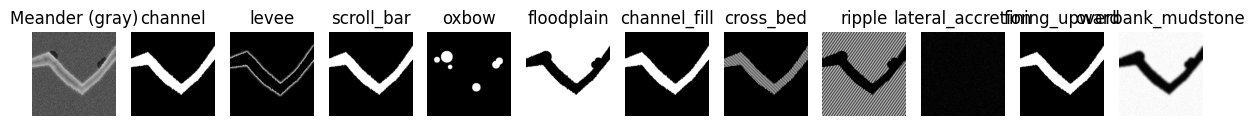

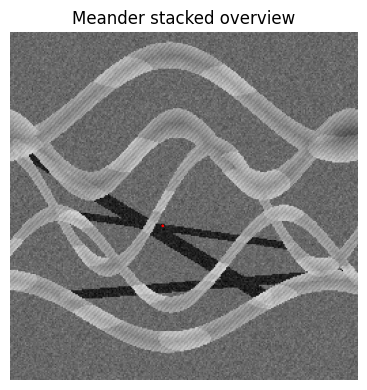

In [20]:
import matplotlib.pyplot as plt
import numpy as np


def _mask_arrays(masks_dict):
    arrays = []
    for name, value in masks_dict.items():
        if isinstance(value, np.ndarray) and value.ndim >= 2:
            arrays.append((name, value.astype(np.float32)))
    return arrays

def _plot_masks(analog, masks_dict, title: str):
    arrays = _mask_arrays(masks_dict)
    fig, axes = plt.subplots(1, len(arrays) + 1, figsize=(12, 4))
    axes[0].imshow(analog, cmap='gray', vmin=0.0, vmax=1.0)
    axes[0].set_title("Meander (gray)")
    axes[0].axis('off')
    for ax, (name, mask) in zip(axes[1:], arrays):
        ax.imshow(mask, cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(name)
        ax.axis('off')
    fig.tight_layout()

analog_single, masks_single = single_meander
_plot_masks(analog_single, masks_single, 'Meander single run')

analog_stacked, masks_stacked = stacked_meander
fig = plt.figure(figsize=(6, 4))
plt.imshow(analog_stacked, cmap='gray', vmin=0.0, vmax=1.0)
package_map = masks_stacked.get('package_id_map')
if isinstance(package_map, np.ndarray) and package_map.ndim >= 2:
    plt.contour(package_map, levels=6, colors='r', linewidths=0.4)
plt.title('Meander stacked overview')
plt.axis('off')
fig.tight_layout()

In [21]:
import pandas as pd

from analog_image_generator import stats as ag_stats


def summarize_metrics(label: str, analog, masks):
    metrics = ag_stats.compute_metrics(analog, masks, env='fluvial')
    display(pd.DataFrame([metrics])[['beta_iso','entropy_global','fractal_dimension','psd_aspect','qa_psd_anisotropy_warning','qa_channel_area_warning']])
    print(f"Metrics recorded for {label}")
    return metrics

single_meander_metrics = summarize_metrics('single', *single_meander)
stacked_meander_metrics = summarize_metrics('stacked', *stacked_meander)

,beta_iso,entropy_global,fractal_dimension,psd_aspect,qa_psd_anisotropy_warning,qa_channel_area_warning
0,0.309562,-75.733333,2.845219,1.031729,False,False


Metrics recorded for single


,beta_iso,entropy_global,fractal_dimension,psd_aspect,qa_psd_anisotropy_warning,qa_channel_area_warning
0,0.489121,-79.288146,2.75544,1.138957,False,False


Metrics recorded for stacked


## anchor-fluvial-meander-centerline
`meander_centerline(H, W, n_ctrl, amp_range, drift_frac, rng)` builds a sinuosity-aware centerline using control points and stochastic drift.

## anchor-fluvial-variable-width
`meander_variable_channel(centerline, shape, w0, w1, rng)` widens/narrows the belt along strike before rasterization.

## anchor-fluvial-levees
`add_levees(chan, iterations)` dilates channel banks and applies a gaussian rim to emulate levees.

## anchor-fluvial-scroll-bars
`add_scroll_bars(chan, lambda_px)` converts EDT bands into cosine scroll textures.

## anchor-fluvial-oxbow
`add_oxbow(centerline, shape, neck_tol, rng)` seeds oxbow scars based on centerline samples.

## anchor-fluvial-compose
`compose_meandering(gray, masks, noise_scale, rng)` normalizes grayscale output and ensures mask metadata stays consistent.

## anchor-fluvial-generate
`generate_meandering(params, rng)` orchestrates the centerline, channel raster, levees, scroll bars, oxbows, and composition before returning `(gray, masks)`.

## anchor-sedimentary-approximations
Sedimentary overlays in this notebook use simplified distance-to-mask gradients, Gaussian-smoothed noise, and deterministic laminae frequencies (no fully resolved laminae or grain-scale physics). Mineralogy percentages are constrained heuristics (`feldspar`, `quartz`, `clay`) summing to 1.0; cement signatures toggle between kaolinite/calcite based on marsh coverage, and mud_clasts_bool reflects overbank fraction. These approximations target qualitative realism for previews/statistics rather than exact petrophysical fidelity.


### anchor-fluvial-stacked-packages

Stacked channel workflows toggle via `params["mode"] = "stacked"`, which calls `analog_image_generator.stacked_channels.build_stacked_fluvial` to mix meandering/braided/anasto packages. 
Sliders feed `package_count`, style lists, and per-package thickness/relief knobs so GEOLOGIC_RULES stays traceable. 
Boundary masks (`upper_surface_mask`, `erosion_surface_mask`, `package_id_map`) and stack metadata propagate to stats/reporting through `masks["realization_metadata"]["stacked_packages"]`.

### anchor-fluvial-compose

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-generate

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-levees

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-meander-centerline

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-oxbow

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-scroll-bars

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-variable-width

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### Reporting hook
- Reporting artifacts (CSV, env PDFs, master PDF) are generated via `python scripts/smoke_test.py`.
- Latest outputs live under `outputs/smoke_report/` and can be attached to demos.
- Use `analog_image_generator.reporting.build_reports` with the metrics rows captured above to regenerate per-env summaries if needed.

In [22]:
import json
from pathlib import Path

TASK_TAG = "fluvial-v1-demo"


def _resolve_taskmaster_tasks() -> Path:
    search_roots = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for root in search_roots:
        candidate = root / '.taskmaster' / 'tasks' / 'tasks.json'
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        "Unable to locate .taskmaster/tasks/tasks.json relative to the notebook "
        "execution directory."
    )


TASKS_FILE = _resolve_taskmaster_tasks()


def override_seed(seed: int = 0, preset_key: str = 'baseline'):
    params = {**MEANDER_PRESETS[preset_key], 'seed': seed}
    analog, masks = gg.generate_fluvial(params)
    print(f"Generated preview for seed={seed} preset={preset_key}")
    return analog, masks


tasks_data = json.loads(TASKS_FILE.read_text())
tasks_snapshot = tasks_data.get(TASK_TAG, {}).get('tasks', [])
tasks_snapshot[:3]


[{'id': '1',
  'title': 'Align fluvial demo notebook skeletons with GEOLOGIC_RULES anchors',
  'description': 'Audit existing fluvial notebooks and craft a repeatable intro/checklist cell pattern that ties every section back to the documented anchors.',
  'details': '- Inventory notebooks under `notebooks/fluvial_*` plus `fluvial_sanity.ipynb` and map each required section (intro, presets, generator runs, metrics, reporting, debug) to anchor IDs defined in `docs/GEOLOGIC_RULES.md`.\n- Create/refresh intro markdown blocks per environment (meandering, braided, anastomosing, stacked, reporting, stats) referencing anchors like ``analog_image_generator.geologic_generators.generate_meandering`` and `anchor-fluvial-overview` in `docs/GEOLOGIC_RULES.md`.\n- Add a standardized checklist markdown cell (✅/⬜) enumerating PRD bullets so QA can tick each feature before sharing with the professor.\n- Pseudo-code:\n```\nfor env in ("meandering","braided","anastomosing","stacked","reporting","stats"):\

### Debug + seed override controls (Meandering)
These controls expose Task Master-ready hooks for overriding seeds, switching between single-belt and stacked packages, and surfacing QA metadata directly inside the notebook. Use them before demos so we can capture screenshots/logs without editing source files.


In [23]:

# Debug + override helper functions for Meandering realizations
import json
from pprint import pprint

import pandas as pd
from IPython.display import Markdown, display

try:
    import ipywidgets as widgets
except ImportError:  # pragma: no cover - executed in notebook
    widgets = None

STYLE_LABEL = "Meandering"

OVERRIDE_STATE = {
    "preset": "baseline",
    "stack_mode": "single",
    "seed": MEANDER_PRESETS["baseline"]["seed"],
}
DEBUG_FLAGS = {
    "show_metadata_table": True,
    "show_debug_accordion": True,
}


def run_fluvial_override(preset_key: str, stack_mode: str, seed: int):
    """Run a single/stacked realization using the requested overrides."""
    params = {**MEANDER_PRESETS[preset_key]}
    params["seed"] = seed
    params["_preset_label"] = preset_key
    params["mode"] = stack_mode if stack_mode == "stacked" else "single"
    if stack_mode == "stacked":
        analog, masks = sc.build_stacked_fluvial(params)
    else:
        analog, masks = gg.generate_fluvial(params)
    return analog, masks, params


def render_metadata_table(masks: dict, params: dict):
    """Display summary + stacked package metadata for Task Master logging."""
    metadata = masks.get("realization_metadata", {})
    summary = {
        "preset": params.get("_preset_label", "baseline"),
        "stack_mode": params.get("mode", "single"),
        "seed": params.get("seed"),
        "package_count": metadata.get("package_count"),
        "erosion_relief_px": metadata.get("erosion_relief_px"),
        "qa_flags": metadata.get("qa_flags"),
    }
    display(pd.DataFrame([summary]))

    packages = metadata.get("stacked_packages")
    if isinstance(packages, dict):
        records = []
        if isinstance(packages.get("packages"), list):
            records.extend(packages["packages"])
        if isinstance(packages.get("stack_statistics"), dict):
            records.append(packages["stack_statistics"])
        if records:
            display(pd.DataFrame.from_records(records))
    elif isinstance(packages, list) and packages:
        display(pd.DataFrame.from_records(packages))

    print("Metadata JSON payload:")
    print(json.dumps(metadata, indent=2))


def build_debug_accordion(analog, masks, params):
    """Use ipywidgets.Accordion to reveal previews + parameter dictionaries on demand."""
    if widgets is None:
        print("ipywidgets unavailable; skipping accordion output.")
        return
    preview_output = widgets.Output()
    with preview_output:
        _plot_masks(analog, masks, f"{STYLE_LABEL} override preview")
    params_output = widgets.Output()
    with params_output:
        pprint(params)
    metadata_output = widgets.Output()
    with metadata_output:
        metadata = masks.get("realization_metadata", {})
        print(json.dumps(metadata, indent=2))
    accordion = widgets.Accordion(children=[preview_output, params_output, metadata_output])
    accordion.set_title(0, "Raw mask preview")
    accordion.set_title(1, "Parameter dictionary")
    accordion.set_title(2, "Metadata JSON")
    display(accordion)


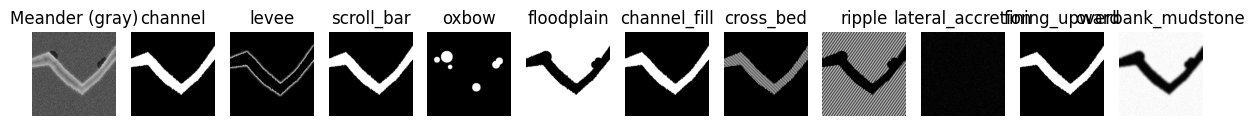

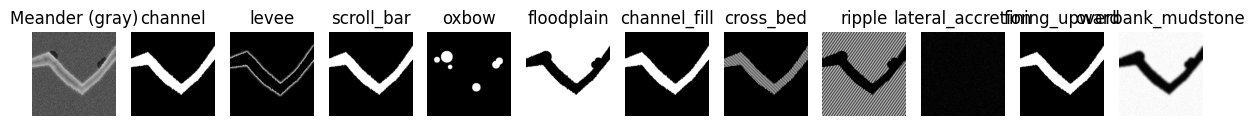

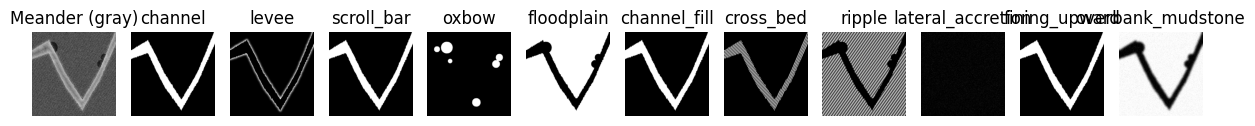

In [24]:
# Interactive override runner for Meandering demos
if widgets is None:
    print(
        "ipywidgets is not installed; adjust OVERRIDE_STATE and call "
        "run_fluvial_override(**OVERRIDE_STATE) manually."
    )
else:
    preset_dropdown = widgets.Dropdown(
        options=sorted(MEANDER_PRESETS.keys()),
        value=OVERRIDE_STATE["preset"],
        description="Preset",
    )
    stack_toggle = widgets.ToggleButtons(
        options=[("Single", "single"), ("Stacked", "stacked")],
        value=OVERRIDE_STATE["stack_mode"],
        description="Mode",
    )
    seed_box = widgets.IntText(value=OVERRIDE_STATE["seed"], description="Seed")
    debug_toggle = widgets.Checkbox(
        value=DEBUG_FLAGS["show_debug_accordion"],
        description="Show accordion",
    )
    output_area = widgets.Output()

    def _run_override(_=None):
        OVERRIDE_STATE.update(
            {
                "preset": preset_dropdown.value,
                "stack_mode": stack_toggle.value,
                "seed": seed_box.value,
            }
        )
        analog, masks, params = run_fluvial_override(
            OVERRIDE_STATE["preset"],
            OVERRIDE_STATE["stack_mode"],
            OVERRIDE_STATE["seed"],
        )
        with output_area:
            output_area.clear_output()
            display(
                Markdown(
                    f"**Override run** → preset `{OVERRIDE_STATE['preset']}`, "
                    f"seed `{OVERRIDE_STATE['seed']}`, "
                    f"mode `{OVERRIDE_STATE['stack_mode']}`"
                )
            )
            render_metadata_table(masks, params)
            if debug_toggle.value:
                build_debug_accordion(analog, masks, params)

    run_button = widgets.Button(description="Run override", button_style="primary")
    run_button.on_click(_run_override)
    display(
        widgets.VBox(
            [
                widgets.HBox([preset_dropdown, stack_toggle, seed_box]),
                debug_toggle,
                run_button,
                output_area,
            ]
        )
    )
    _run_override()


### Debug + QA checklist (Meandering)
- [ ] Captured a seed override + mode toggle screenshot for Task Master notes
- [ ] Logged metadata table output into `.taskmaster/tasks/tasks.json` (Task 7 subtask 3)
- [ ] Expanded the debug accordion to verify raw masks + parameter dictionaries
- [ ] Re-ran `python scripts/validate_geo_anchors.py` and `python scripts/smoke_test.py`
- [ ] Checked this notebook in Git with updated outputs after verifying overrides
